In [ ]:
# Heavily inspired by these:
# https://github.com/yitu-opensource/T2T-ViT
# https://towardsdatascience.com/vision-transformers-explained-a9d07147e4c8

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, in_dim=None, qkv_bias=False, qk_scale=None, attention_drop=0.0, projection_drop=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.in_dim = in_dim
        head_dimensions = dim // num_heads
        self.scale = qk_scale or head_dimensions ** (-0.5)

        self.qkv = nn.Linear(dim, in_dim * 3, bias=qkv_bias)
        self.attention_drop = nn.Dropout(attention_drop)
        self.projection = nn.Linear(in_dim, in_dim)
        self.projection_drop = nn.Dropout(projection_drop)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.in_dim).permutate(2, 0, 3, 1, 4)
        print(qkv)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attention = (q * self.scale) @ k.transpose(-2, -1)
        attention = attention.softmax(dim=-1)
        attention = self.attention_drop(attention)

        x = (attention @ v).transpose(1, 2).reshape(B, N, self.in_dim)
        x = self.projection(x)
        x = self.projection_drop(x)

        x = v.squeeze(1) + x
        return x

In [27]:
class PatchTokenizer(nn.Module):
    def __init__(self, img_size=(1, 1, 60, 100), patch_size=50, token_len=768):
        super().__init__()
        self.img_size = img_size
        C, H, W = self.img_size
        print(img_size)
        print(C, H, W)
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0
        assert W % self.patch_size == 0
        self.num_tokens = (H / self.patch_size) * (W / self.patch_size)

        self.split = nn.Unfold(
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding=0
        )
        self.project = nn.Linear((self.patch_size ** 2) * C, token_len)

    def forward(self, x):
        print('calling supperior forward function')
        x = self.split(x).transpose(1,0)
        x = self.project(x)
        return x

In [4]:
def get_sinusoid_encoding(num_tokens, token_len):
    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(x) for x in range(num_tokens)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

In [5]:
class MultipleLayerPerceptron(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fully_connected1 = nn.Linear(in_features, hidden_features)
        self.activateion = act_layer()
        self.fully_connected2 = nn.Linear(hidden_features, out_features)
        sefl.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fully_connected1(x)
        x = self.activation(x)
        x = self.drop(x)
        x = self.fully_connected2(x)
        x = self.drop(x)
        return x

In [6]:
class Encoding(nn.Module):
    def __init__(self, dim, num_heads=1, hidden_chan_mul=4.0, qkv_bias=False, qk_scale=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.attention = Attention(
            dim=dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
        )
        self.norm2 = norm_layer(dim)
        hidden_features = int(dim * hidden_chan_mul)
        self.mlp = self.MultipleLayerPerceptron(
            in_feautres=dim,
            hidden_features=hidden_features,
            out_features=dim,
            act_layer=act_layer
        )

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [10]:
wtxt = np.load('image.npy')
H, W, _ = wtxt.shape
print(H, W)

40 560


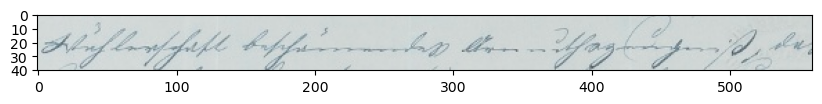

In [19]:
fig = plt.figure(figsize=(10,6))
plt.imshow(wtxt)
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])

In [30]:
P = 20
N = int((H*W)/(P**2))
print(P, N)
print('Token len:', P**2)

20 56
Token len: 400


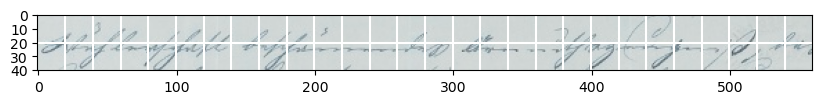

In [22]:
fig = plt.figure(figsize=(10,6))
plt.imshow(wtxt)
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])